In [ ]:
from google.colab import drive
import zipfile
import os
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/train.zip'
extract_path = '/content/dataset/train'

# 3. Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset extracted to: /content/dataset/train


Loading datasets...
Found 7395 files belonging to 7 classes.
Using 5916 files for training.
Found 7395 files belonging to 7 classes.
Using 1479 files for validation.

Detected classes:
Class 0: Expected 'banana_overripe', Found 'banana_overripe'
Class 1: Expected 'banana_ripe', Found 'banana_ripe'
Class 2: Expected 'banana_rotten', Found 'banana_rotten'
Class 3: Expected 'banana_unripe', Found 'banana_unripe'
Class 4: Expected 'tomato_fully_ripened', Found 'tomato_fully_ripened'
Class 5: Expected 'tomato_green', Found 'tomato_green'
Class 6: Expected 'tomato_half_ripened', Found 'tomato_half_ripened'

Calculating class weights...
Class weights: {0: 0.6628571428571428, 1: 0.6702163815565877, 2: 0.4829387755102041, 3: 0.696163803247823, 4: 5.0, 5: 2.761904761904762, 6: 5.0}

Tomato class indices: [4, 5, 6]

Building model...

=== Phase 3: Training Head ===
Epoch 1/30
    185/Unknown 58s 222ms/step - accuracy: 0.7501 - loss: 0.6803 - precision: 0.8008 - recall: 0.6979

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


185/185 ━━━━━━━━━━━━━━━━━━━━ 80s 342ms/step - accuracy: 0.7506 - loss: 0.6795 - precision: 0.8012 - recall: 0.6985 - val_accuracy: 0.9175 - val_loss: 0.2322 - val_precision: 0.9269 - val_recall: 0.9094 - learning_rate: 0.0010
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9009 - loss: 0.3117 - precision: 0.9093 - recall: 0.8886 - val_accuracy: 0.9297 - val_loss: 0.1913 - val_precision: 0.9374 - val_recall: 0.9216 - learning_rate: 0.0010
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9152 - loss: 0.2659 - precision: 0.9221 - recall: 0.9078 - val_accuracy: 0.9358 - val_loss: 0.1767 - val_precision: 0.9433 - val_recall: 0.9331 - learning_rate: 0.0010
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9276 - loss: 0.2217 - precision: 0.9324 - recall: 0.9246 - val_accuracy: 0.9337 - val_loss: 0.1749 - val_precision: 0.9373 - val_recall: 0.9297 - learning_rate: 0.0010
Epoch 5/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.

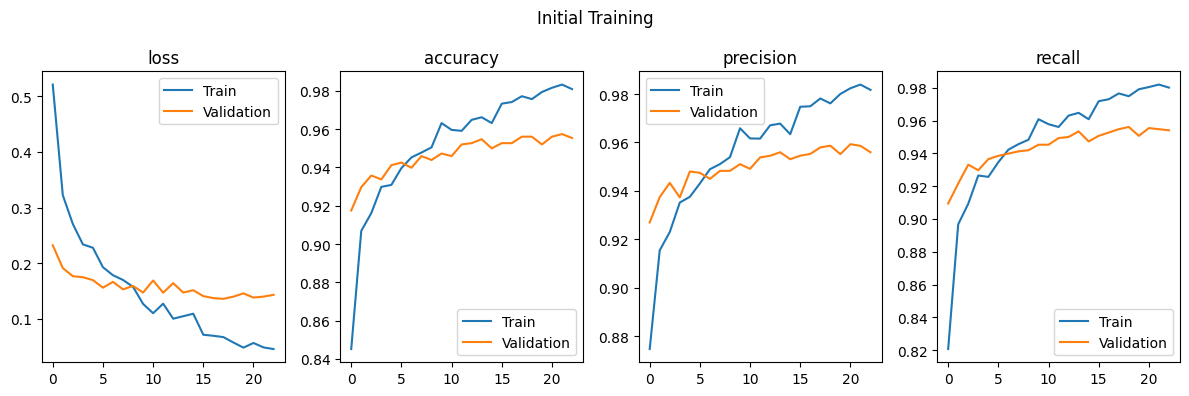

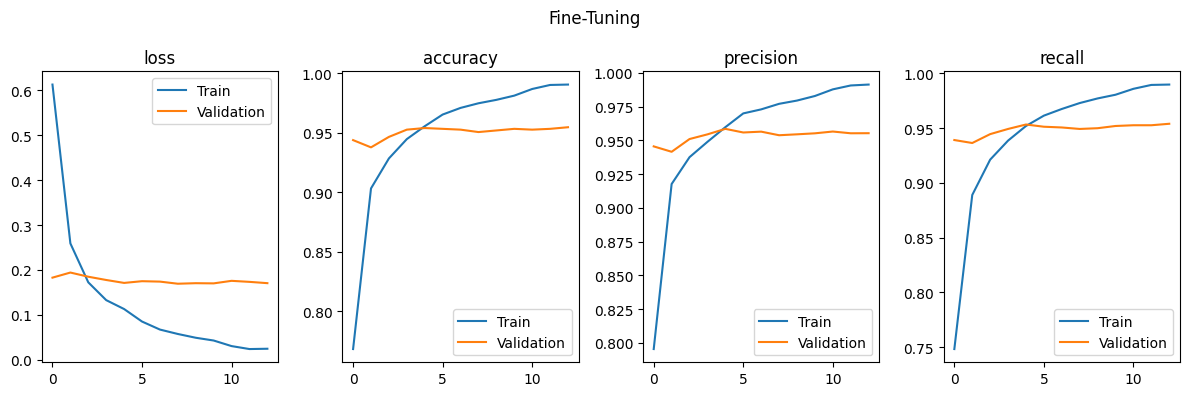

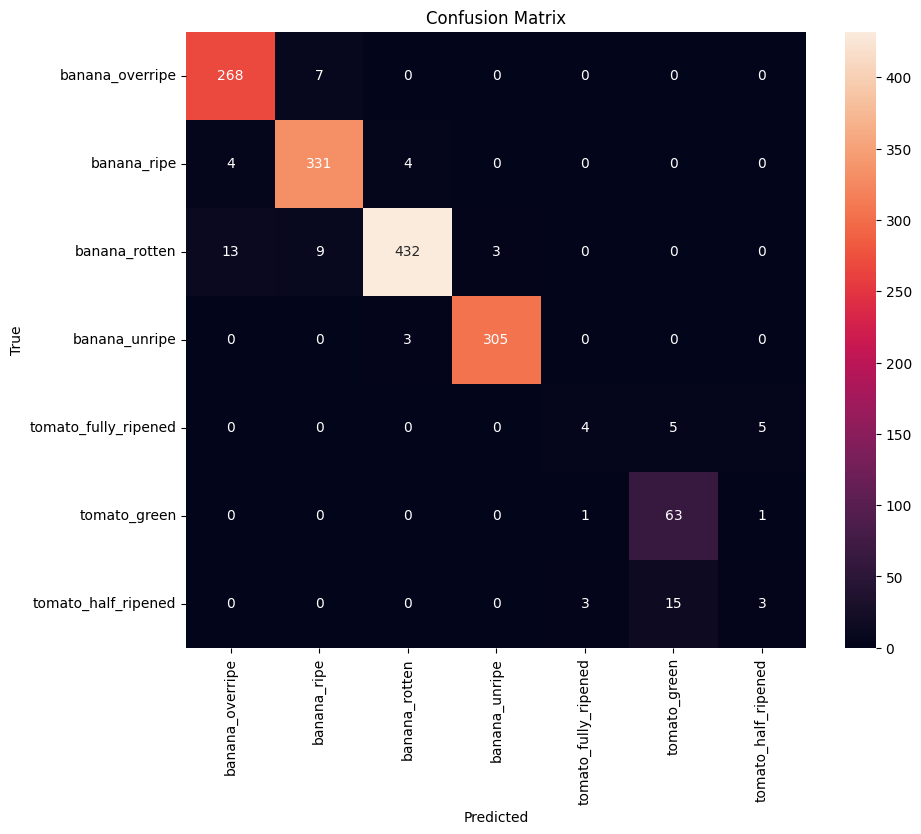

Available layers in base model:
1: Conv1
2: bn_Conv1
3: Conv1_relu
4: expanded_conv_depthwise
5: expanded_conv_depthwise_BN
6: expanded_conv_depthwise_relu
7: expanded_conv_project
8: expanded_conv_project_BN
151: Conv_1
152: Conv_1_bn

Using layer for Grad-CAM: Conv_1_bn


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_480']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m140186930719440\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)\n  • training=None\n  • mask=None'

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import os
import seaborn as sns
from tensorflow.keras import mixed_precision

# ------------------ CONFIG ------------------
tf.random.set_seed(42)
np.random.seed(42)

# Enable mixed precision for faster training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

img_size = 224
batch_size = 32
dataset_path = '/content/dataset/train/train'

# ------------------ CLASS MAPPING ------------------
expected_classes = {
    0: 'banana_overripe',
    1: 'banana_ripe',
    2: 'banana_rotten',
    3: 'banana_unripe',
    4: 'tomato_fully_ripened',
    5: 'tomato_green',
    6: 'tomato_half_ripened'
}

# ------------------ DATA LOADING ------------------
print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

# Get class names and verify
class_names = train_ds.class_names
print("\nDetected classes:")
for idx, name in expected_classes.items():
    print(f"Class {idx}: Expected '{name}', Found '{class_names[idx]}'")

# ------------------ CLASS WEIGHTS ------------------
print("\nCalculating class weights...")
labels = np.concatenate([y.numpy().argmax(1) for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = {i: min(float(w), 5.0) for i, w in enumerate(class_weights)}  # Cap weights at 5.0
print("Class weights:", class_weights)

# ------------------ AUGMENTATIONS ------------------
def general_augmentations(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

def tomato_specific_augmentations(image):
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    return image

# Identify tomato classes dynamically
tomato_keywords = ['tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']
tomato_indices = [i for i, name in enumerate(class_names)
                 if any(kw in name.lower() for kw in tomato_keywords)]
tomato_tensor = tf.constant(tomato_indices, dtype=tf.int64)
print("\nTomato class indices:", tomato_indices)

# ------------------ DATA PROCESSING ------------------
def process_train(image, label):
    class_idx = tf.argmax(label)
    image = general_augmentations(image)
    is_tomato = tf.reduce_any(tf.equal(class_idx, tomato_tensor))
    image = tf.cond(is_tomato,
                   lambda: tomato_specific_augmentations(image),
                   lambda: image)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)# change with different model
    return image, label

def process_val(image, label):
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)# change with different model
    return image, label

# ------------------ DATA PIPELINE ------------------
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (train_ds.unbatch()
           .map(process_train, num_parallel_calls=AUTOTUNE)
           .batch(batch_size)
           .cache()
           .prefetch(AUTOTUNE))

val_ds = (val_ds.unbatch()
         .map(process_val, num_parallel_calls=AUTOTUNE)
         .batch(batch_size)
         .cache()
         .prefetch(AUTOTUNE))

# ------------------ MODEL SETUP ------------------
print("\nBuilding model...")
def build_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_size, img_size, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    base_model.trainable = False  # Freeze initially

    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    outputs = tf.keras.layers.Dense(
        len(expected_classes),
        activation='softmax',
        dtype='float32'  # Ensure output is float32 for stability
    )(x)

    return tf.keras.Model(inputs, outputs), base_model

model, base_model = build_model()

# ------------------ CALLBACKS ------------------
def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=5, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7
        ),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_model.keras',  # Now ends with .keras
            save_best_only=True,
            monitor='val_loss'
        )
    ]


# ------------------ PHASE 3: INITIAL TRAINING ------------------
print("\n=== Phase 3: Training Head ===")
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=get_callbacks()
)

# ------------------ PHASE 4: FINE-TUNING ------------------
def unfreeze_model(base_model, model, unfreeze_layers=100):
    base_model.trainable = True
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ] #Include precision and recall in metrics
    )
    return model

print("\n=== Phase 4: Fine-Tuning ===")
model = unfreeze_model(base_model, model, unfreeze_layers=100)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=get_callbacks()
)

# ------------------ PHASE 5: EVALUATION ------------------
print("\n=== Phase 5: Evaluation ===")
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    for i, metric in enumerate(metrics):
        plt.subplot(1, 4, i+1)
        plt.plot(history.history[metric], label='Train')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label='Validation')
        plt.title(metric)
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_training_history(history, "Initial Training")
plot_training_history(history_fine, "Fine-Tuning")

# Confusion Matrix
def plot_confusion_matrix(dataset, model):
    y_true = []
    y_pred = []
    for images, labels in dataset:
        y_true.extend(tf.argmax(labels, axis=1).numpy())
        y_pred.extend(tf.argmax(model.predict(images, verbose=0), axis=1))

    cm = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g',
                xticklabels=expected_classes.values(),
                yticklabels=expected_classes.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(val_ds, model)

# Grad-CAM Visualization
# ------------------ GRAD-CAM VISUALIZATION (CORRECTED) ------------------
def generate_grad_cam(model, image, layer_name='Conv_1'):
    # Get the actual convolutional layer from the base model
    conv_layer = base_model.get_layer(layer_name)

    # Create gradient model
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(tf.expand_dims(image, axis=0))
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)[0]
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

def visualize_grad_cam(dataset, model, num_samples=3):
    # First print available layers for debugging
    print("Available layers in base model:")
    for i, layer in enumerate(base_model.layers):
        if 'conv' in layer.name.lower():
            print(f"{i}: {layer.name}")

    # Use the last convolutional layer (typically good for Grad-CAM)
    last_conv_layer = None
    for layer in base_model.layers[::-1]:
        if 'conv' in layer.name.lower():
            last_conv_layer = layer.name
            break

    if last_conv_layer is None:
        print("Warning: No convolutional layer found in base model!")
        return

    print(f"\nUsing layer for Grad-CAM: {last_conv_layer}")

    for images, labels in dataset.take(1):
        for i in range(min(num_samples, images.shape[0])):
            image = images[i]
            label = labels[i]

            # Reverse MobileNetV2 preprocessing for visualization
            image_vis = (image + 1) / 2  # Scale to [0,1]

            heatmap = generate_grad_cam(model, image, layer_name=last_conv_layer)

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(image_vis)
            plt.title(f"True: {expected_classes[tf.argmax(label).numpy()]}")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(image_vis)
            plt.imshow(heatmap, cmap='jet', alpha=0.5)
            plt.title(f"Grad-CAM ({last_conv_layer})")
            plt.axis('off')
            plt.show()

visualize_grad_cam(val_ds, model)